In [75]:
import osmnx as ox
import pandas as pd
from pathlib import Path
import numpy as np
import src.geo_transform as gt
import networkx as nx
import logging
import src.wrangle_bbr as wrangle
ox.settings.log_console = True
ox.settings.use_cache=True

logging.basicConfig(level=logging.INFO)

In [90]:
DATA_DIR = Path("data")
df = pd.read_csv(DATA_DIR / "gas_fjernvarme_xy.csv")

In [16]:
df.columns

Index(['ID', 'kommunekode', 'gas_x', 'gas_y', 'distance', 'fjernvarme_x',
       'fjernvarme_y'],
      dtype='object')

In [3]:
odsherred_id = 306
place = "Odsherred Municipality"
G = ox.graph_from_place(place, network_type="walk")

In [4]:
Gp = ox.project_graph(G)

In [9]:
Gp.graph["crs"]

<Derived Projected CRS: +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [77]:
odsherred_df = df[df["kommunekode"] == odsherred_id]

In [72]:
odsherred_df.columns

Index(['ID', 'kommunekode', 'gas_x', 'gas_y', 'distance', 'fjernvarme_x',
       'fjernvarme_y'],
      dtype='object')

In [92]:
kommune_values = df["kommunekode"].value_counts()
gas_kommune = kommune_values[kommune_values > 1000].index

In [93]:
df[df["kommunekode"].isin(gas_kommune)].groupby("kommunekode")["distance"].mean().sort_values().tail(1)

kommunekode
580    3088.04021
Name: distance, dtype: float64

In [124]:
df.columns

Index(['ID', 'kommunekode', 'gas_lat', 'gas_long', 'distance',
       'fjernvarme_lat', 'fjernvarme_long'],
      dtype='object')

In [78]:
gas_nodes, gasdists = ox.distance.nearest_nodes(Gp, odsherred_df["gas_x"].tolist(), odsherred_df["gas_y"].tolist(), return_dist=True,)
fjern_nodes, dists = ox.distance.nearest_nodes(Gp, odsherred_df["fjernvarme_x"].tolist(), odsherred_df["fjernvarme_y"].tolist(), return_dist=True,)

In [84]:
odsherred_df["fjernvarme_x"].describe()

count      1816.000000
mean     597635.995347
std       95632.990521
min      444909.500000
25%      510572.930000
50%      567862.810000
75%      675447.600000
max      891553.450000
Name: fjernvarme_x, dtype: float64

In [88]:
odsherred_df["fjernvarme_y"].describe().round(2)

count       1816.00
mean     6226166.93
std        78669.64
min      6061281.21
25%      6175283.82
50%      6220982.41
75%      6246446.83
max      6399572.43
Name: fjernvarme_y, dtype: float64

In [85]:
odsherred_df["gas_x"].describe()

count      1816.000000
mean     655060.957620
std        1691.066956
min      651281.090000
25%      653895.055000
50%      654664.100000
75%      656471.742500
max      671192.660000
Name: gas_x, dtype: float64

In [86]:
odsherred_df["gas_y"].describe()

count    1.816000e+03
mean     6.185409e+06
std      3.153762e+03
min      6.179974e+06
25%      6.181703e+06
50%      6.185487e+06
75%      6.188205e+06
max      6.204741e+06
Name: gas_y, dtype: float64

In [84]:
assert all(node in Gp.nodes for node in gas_nodes)
assert all(node in Gp.nodes for node in fjern_nodes)

In [32]:
len(set(fjern_nodes))

25

In [40]:
#lengths = nx.shortest_path_length(G=Gp, source=gas_nodes, target=fjern_nodes, weight='length')

lengths = np.zeros(len(gas_nodes))
assert lengths.shape == (len(gas_nodes),)
for i, (gas, fjern) in enumerate(zip(gas_nodes, fjern_nodes)):
    length = nx.shortest_path_length(G=Gp, source=gas, target=fjern, weight='length')
    lengths[i] += length

<AxesSubplot:ylabel='Frequency'>

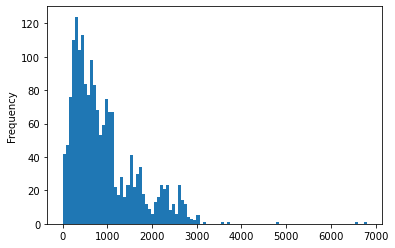

In [44]:
pd.Series(lengths).plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

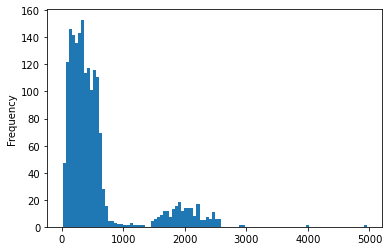

In [46]:
odsherred_df["distance"].plot.hist(bins=100)

In [38]:
node_colors = ["green" if node in fjern_nodes else "red" if node in gas_nodes else "white" for node in Gp.nodes]
node_alpha = [0.3 if col == "white" else 1 for col in node_colors]


In [36]:
(np.array(node_colors) == "red").sum()
(np.array(node_colors) == "green").sum()


25

In [103]:
np.unique(gas_nodes)

array([4687643000], dtype=int64)

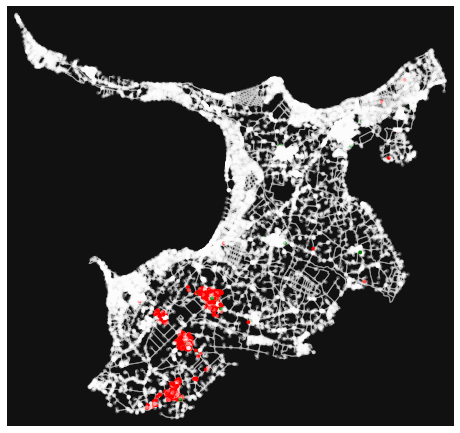

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
ox.plot_graph(Gp, node_color=node_colors, node_alpha=node_alpha)

In [95]:
odsherred_df["road_dist"] = lengths

C:\Users\jhr\AppData\Local\Temp\ipykernel_7056\1826409843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odsherred_df["road_dist"] = lengths
